In [1]:
using Revise

using ramnet
using ramnet.Encoders
using ramnet.Utils: accuracy

using StatsBase: msd, rmsd

using Random
using StatsPlots
using Distributions

using Printf

pyplot()

Plots.PyPlotBackend()

# Regression with Weightless Neural Networks

In [26]:
function mean_squared_error(y_pred, y_test)
    s = 0.0
    for (pred, test) in Iterators.zip(y_pred, y_test)
        s += (pred - test)^2
    end
    
    s/ length(y_pred)
end

mean_squared_error (generic function with 1 method)

## Linear data

In [2]:
function line_dataset(N; seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed) 
    intercepts = rand(rng, 2)
    a, b = -intercepts[2]/intercepts[1], intercepts[2]

    X = rand(rng, Float64, N)
    y = a*X .+ b

    return X, y
end

line_dataset (generic function with 1 method)

Mean squared deviation: 0.46757143866233136


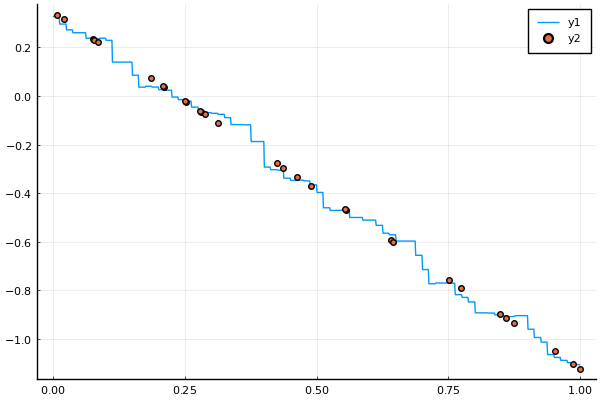

In [57]:
X, y = line_dataset(30; seed=1)

thermo = Thermometer(0.0, 1.0, 80)
X_encoded = permutedims(encode(thermo, X; flat=false))

model = RegressionDiscriminator(80, 20; seed=1, γ=1.0)

train!(model, X_encoded, y)

# Testing
X_test, y_test = line_dataset(4000; seed=32)
y_pred = predict(model, permutedims(encode(thermo, X_test; flat=false)))
println("Mean squared deviation: $(msd(y_pred, y_test))")

plot((x) -> predict(model, encode(thermo, x)), 0:0.001:1)
scatter!(X, y)

## Non-linear data

In [34]:
function wiggly_dataset(N; seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    wiggly(x) = sin(10*π*(x + 1)^(-3))
    
    X = rand(rng, Float64, N)
    
    return X, wiggly.(X)
end

wiggly_dataset (generic function with 1 method)

Mean squared deviation: 0.02275098763927742


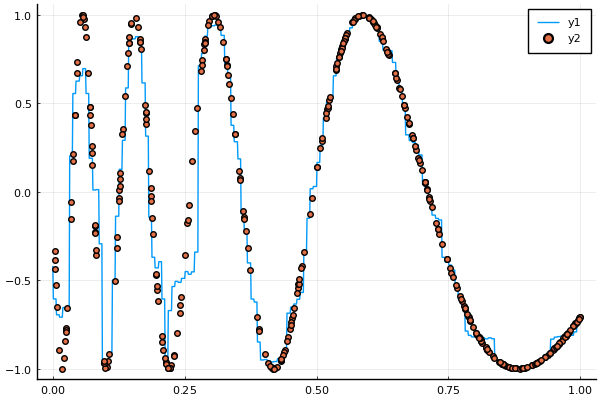

In [40]:
X, y = wiggly_dataset(400; seed=3)

thermo = Thermometer(0.0, 1.0, 160)
X_encoded = permutedims(encode(thermo, X; flat=false))

model = RegressionDiscriminator(160, 80; seed=1, γ=1.0)

train!(model, X_encoded, y)

# Testing
X_test, y_test = wiggly_dataset(4000; seed=32)
y_pred = predict(model, permutedims(encode(thermo, X_test; flat=false)))
println("Mean squared deviation: $(msd(y_pred, y_test))")

plot((x) -> predict(model, encode(thermo, x)), 0:0.001:1)
scatter!(X, y)

## Non-stationarity

In the previous examples, we could see that the model is able to adequately approximate both linear and nonlinear functions, but these shared one characteristic: they represented stationary tasks. All samples were drawn uniformly from their respective underlying and unchanging processes. However, not all tasks that are of interest to us share in these conditions. In a reinforcement learning setting, for example, we are usually interested in finding high-valued polices. One possible way of finding such policies is to start with a arbitrary one and iteratively improve it by interating with the environment, collecting data, using it to model the policy's value and conceiving a new, hopefully improved policy acording to the approximate value function. One difficulty presented by this approach is that the value function we strive to approximate is a constantly moving target. That is: it is nonstationary. How does the n-tuple regression network fare under a nonstationary setting such as this one?

In [100]:
function polynomial(c_5, c_4, c_3, c_2, c_1, c_0)
    x -> c_5*x^5 + c_4*x^4 + c_3*x^3 + c_2*x^2 + c_1*x + c_0
end

function nonstationary(seed=nothing; γ=1.0)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    
    coefs = [
        ( 0.0,  0.0,  0.0, 0.0, 1.0, 0.0),
        ( 0.0,  0.0,  0.0, 0.3, 1.0, 0.0),
        ( 0.0,  0.0, -0.3, 0.3, 1.0, 0.0),
        ( 0.0, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.3, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.4, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0)
    ]
    
    plots = Vector{Plots.Plot}(undef, 9)
    MSEs = Vector{Float64}(undef, 900)
    
    thermo = Thermometer(-1.0, 1.0, 160)
    regressor = RegressionDiscriminator(160, 80; seed, γ)
    
    for (i, coef) in Iterators.enumerate(coefs)
        poly = polynomial(coef...)
        
        # Plot target function
        plots[i] = plot(poly, -1:0.001:1)
        
        # Sample points from target function to train model and assess quality
        X_train = rand(Uniform(-1, 1), 100)
        y_train = poly.(X_train)
        
        X_test = rand(Uniform(-1, 1), 1000)
        y_test = poly.(X_test)
        
        # Train regression model
        for (j, x, target) in Iterators.zip(
                1:length(X_train),
                eachrow(permutedims(encode(thermo, X_train; flat=false))),
                y_train)
           train!(regressor, x, target)
            
            MSEs[(i-1)*length(X_train) + j] = msd(
                predict(regressor, permutedims(encode(thermo, X_test; flat=false))),
                y_test
            )
        end
        
        # Plot regression curve
        plot!(
            plots[i],
            (x) -> predict(regressor, encode(thermo, x)),
            -1:0.001:1,
            title=@sprintf("MSE: %.2e", MSEs[i]),
            titlefont=font(9)
        )
    end
    
    l = @layout [grid(3,3); a{0.3h}]
    
    plot(
        plots...,
        plot(MSEs[50:end]),
        layout=l,
        size=(1000, 1300),
        legend=false,
        dpi=200
    )
end

nonstationary (generic function with 2 methods)

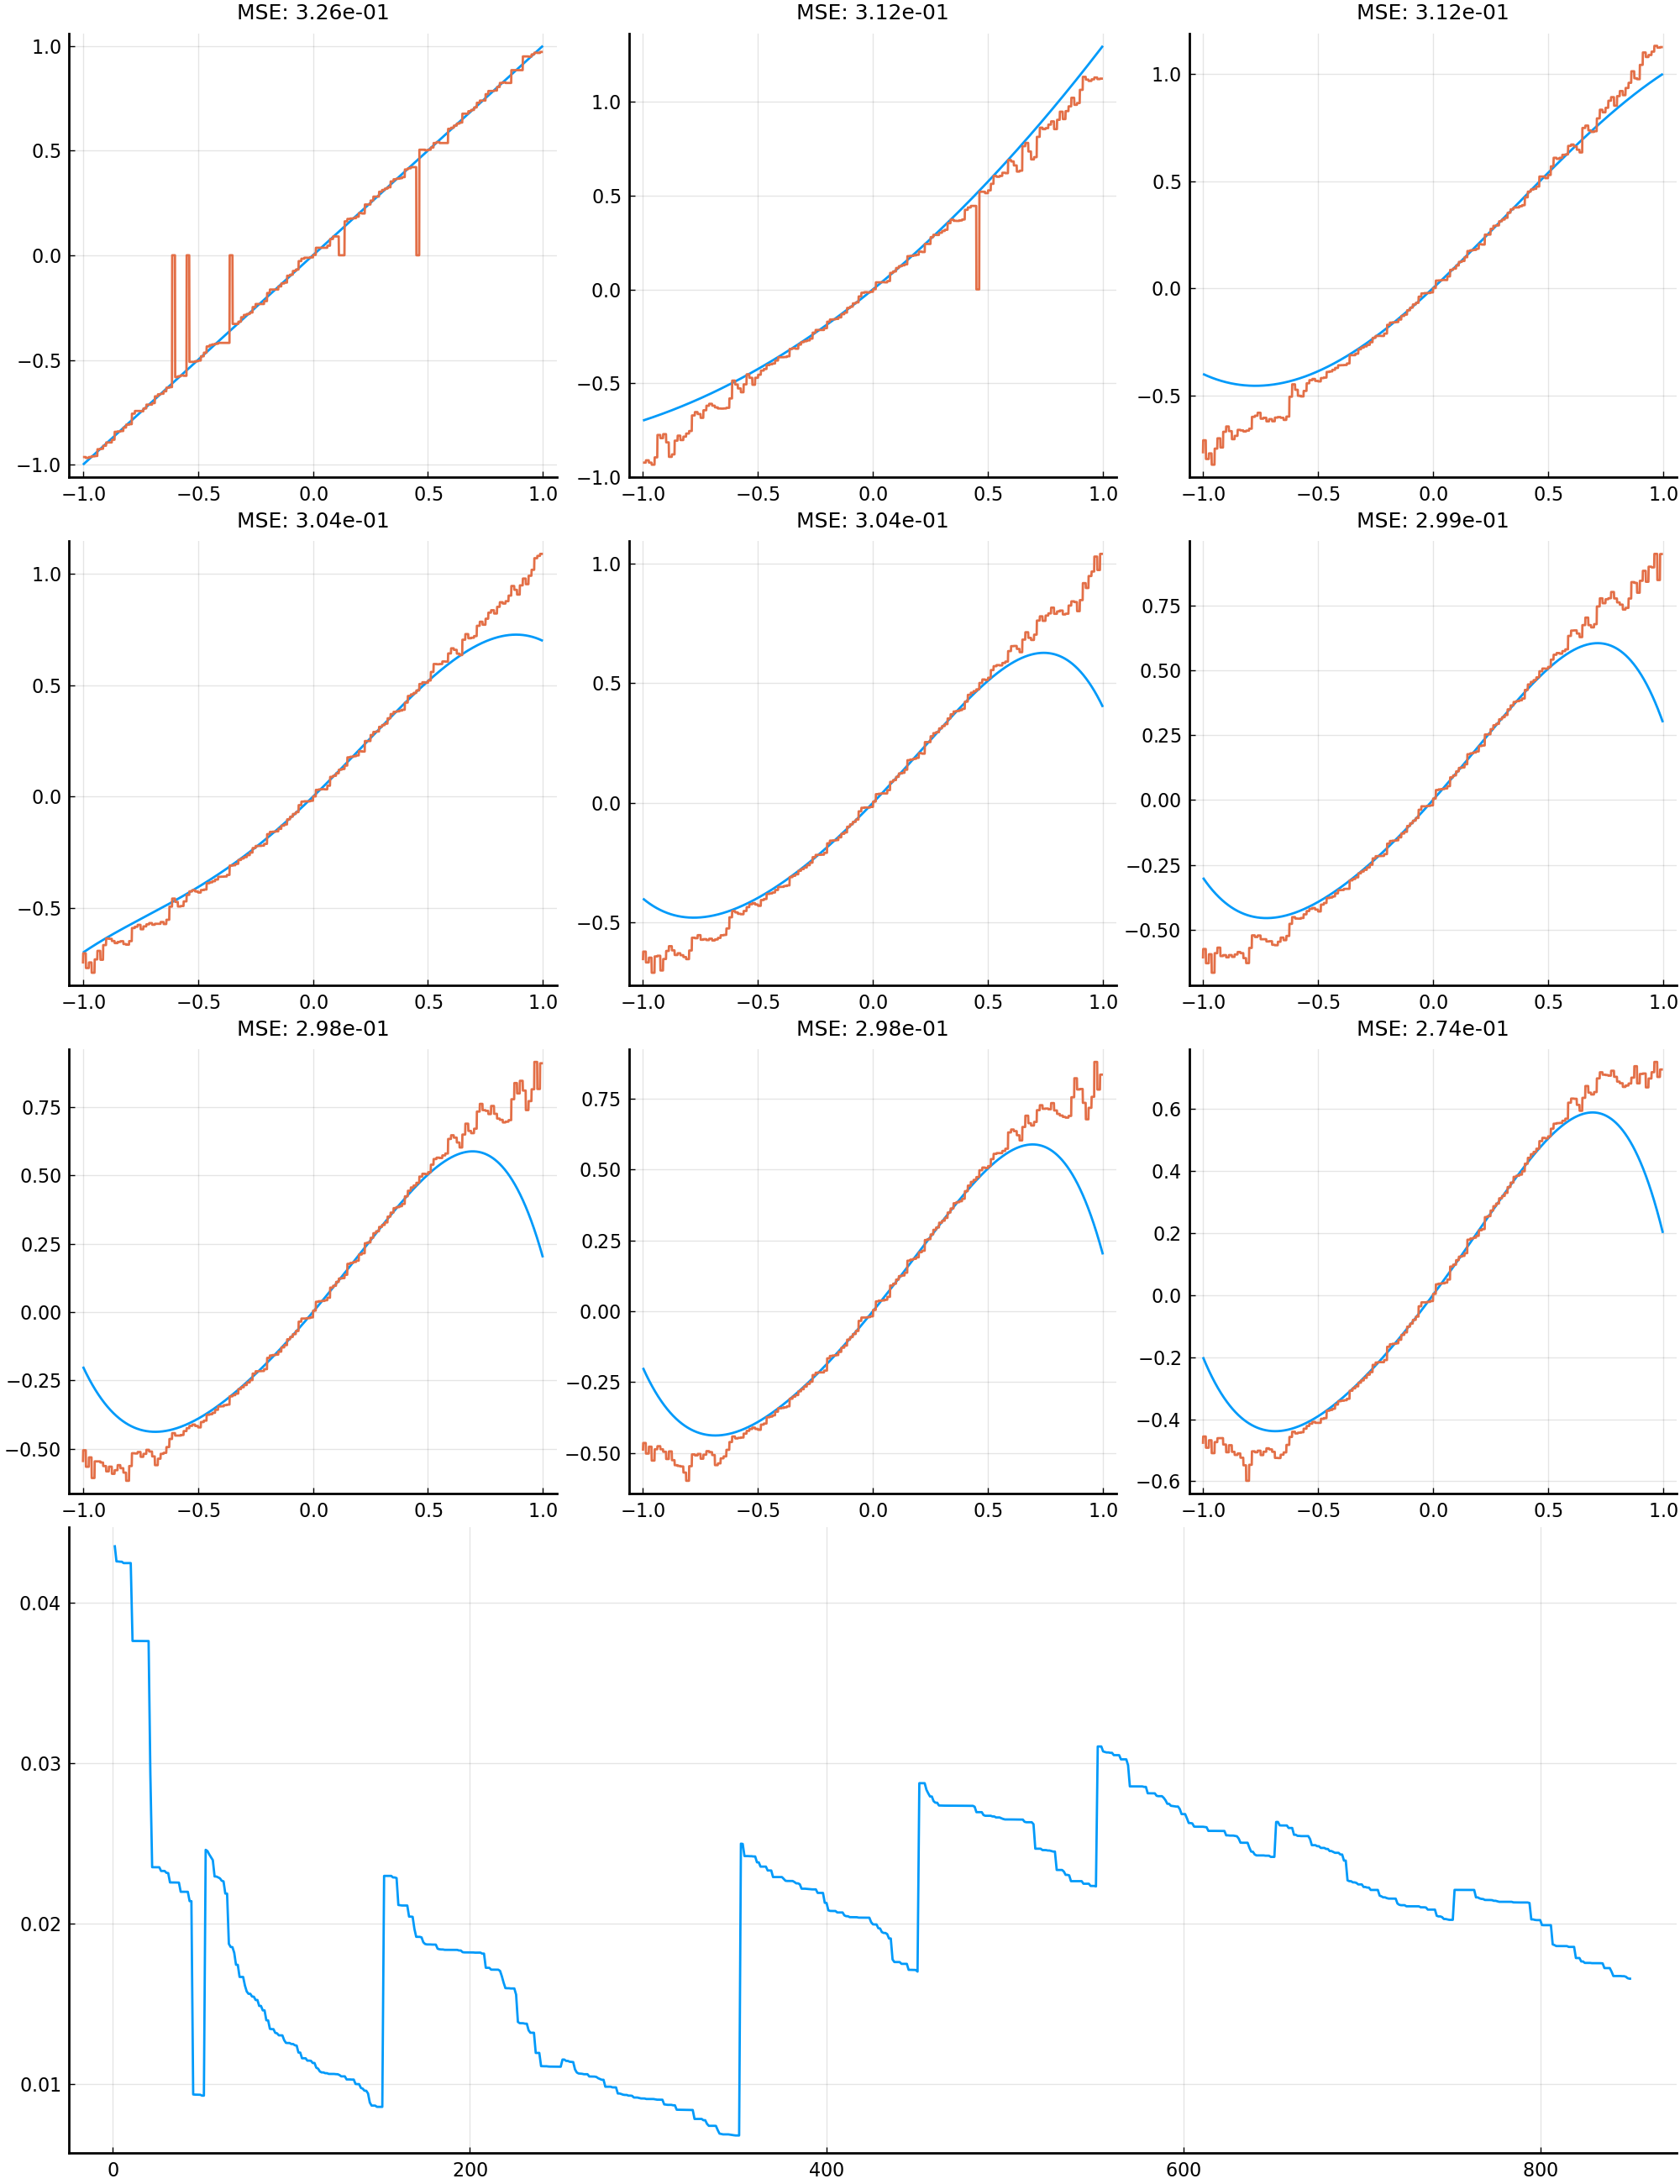

In [102]:
nonstationary(2; γ = 1.0)

## What if we penalize older samples?

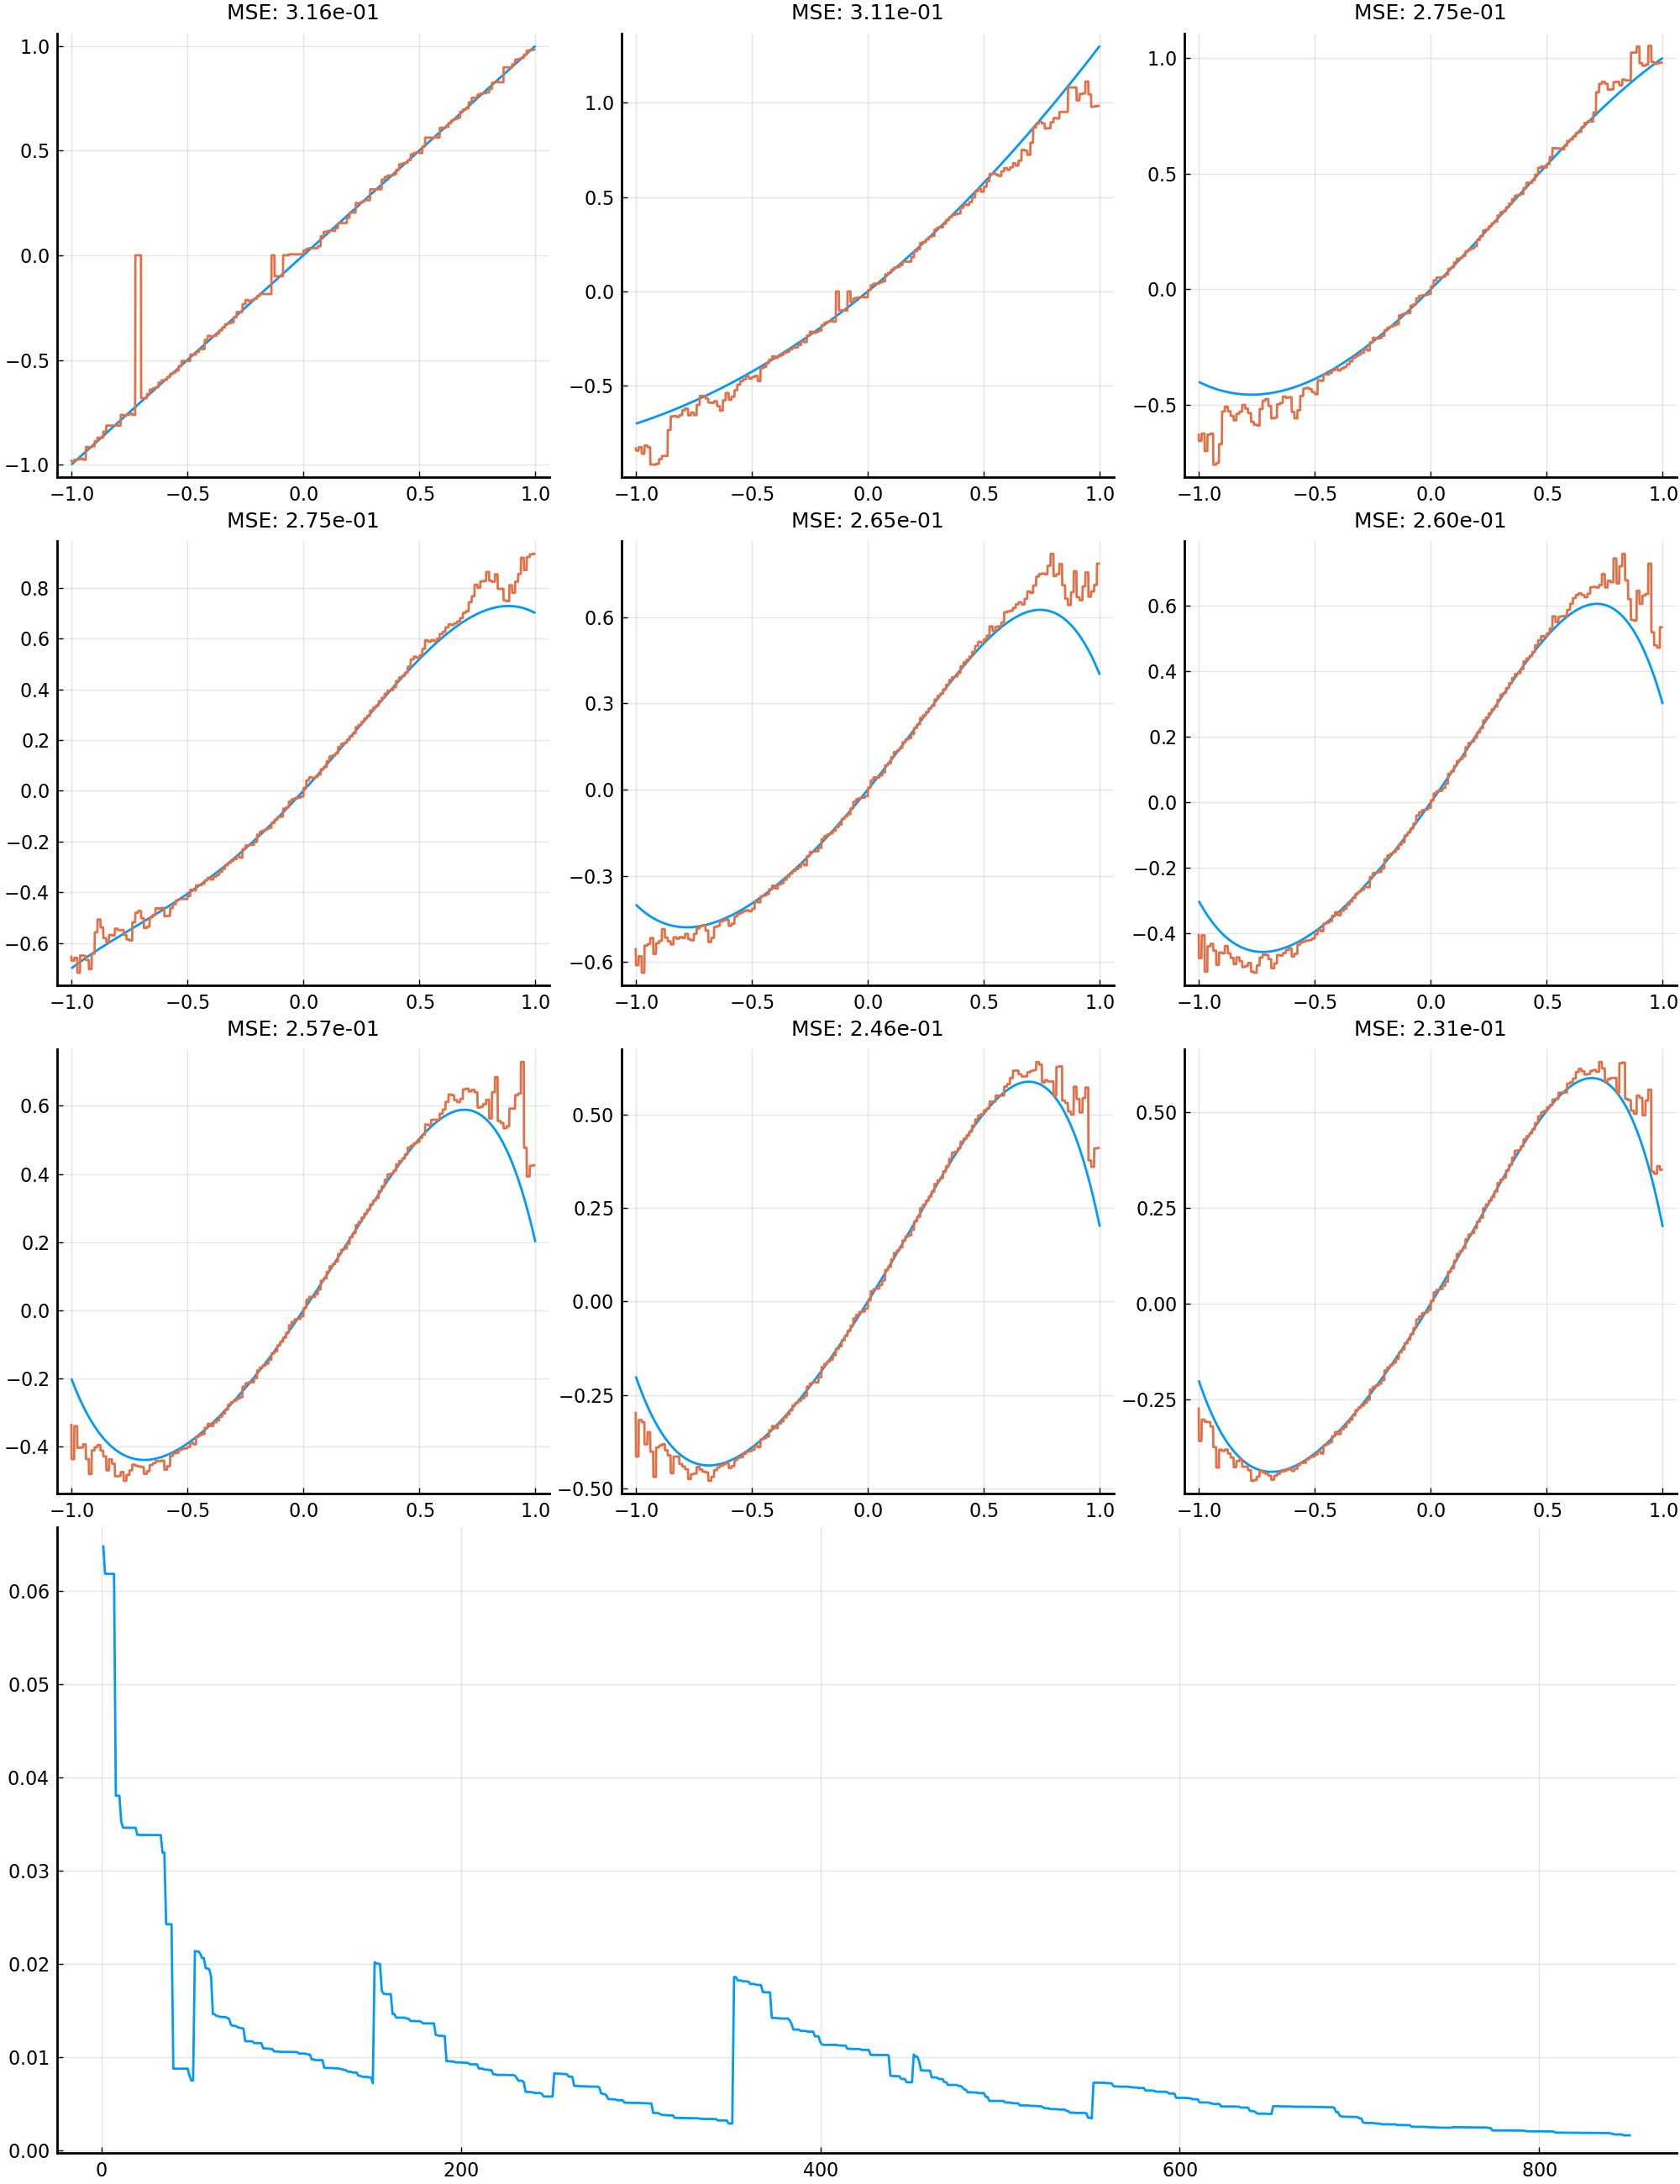

In [103]:
nonstationary(2; γ = 0.75)